In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from collections import OrderedDict
from PIL import Image
import random
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models

In [2]:
data_dir = 'data_smaller'
age_labels = []
image_paths = []

image_filenames = os.listdir(data_dir)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(data_dir, image)
  img_components = image.split('_')
  age_label = int(img_components[0])

  age_labels.append(age_label)
  image_paths.append(image_path)
    

print(f'Number of age_labels: {len(age_labels)}, Number of image_paths: {len(image_paths)}')

  0%|          | 0/9780 [00:00<?, ?it/s]

Number of age_labels: 9780, Number of image_paths: 9780


In [3]:
df = pd.DataFrame()
df['image_path'], df['age'] = image_paths, age_labels
df.head(5)

,image_path,age
0,data_smaller\26_1_3_20170104222627929.jpg.chip...,26
1,data_smaller\6_1_0_20170109194012135.jpg.chip.jpg,6
2,data_smaller\41_0_0_20170109012220690.jpg.chip...,41
3,data_smaller\14_0_0_20170110232127519.jpg.chip...,14
4,data_smaller\10_0_4_20170103200443015.jpg.chip...,10


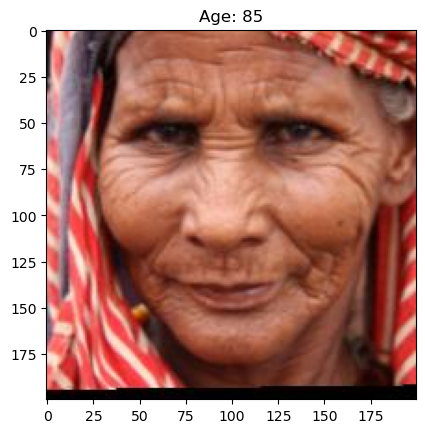

In [4]:
rand_idx = random.randint(0, len(image_paths))
age = df['age'][rand_idx]
img = Image.open(df['image_path'][rand_idx])
plt.title(f'Age: {age}')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

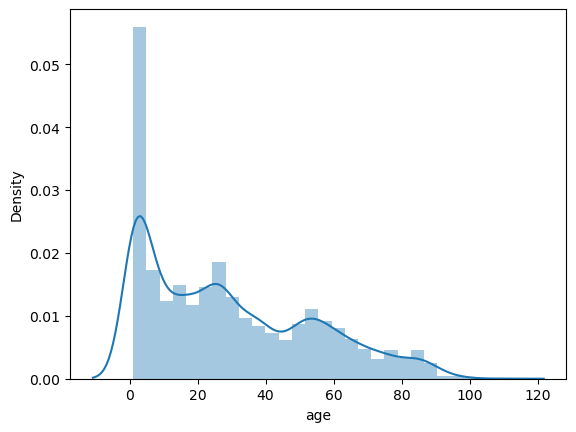

In [5]:
sb.distplot(df['age'])

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class AgeDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)
        age = float(self.images[idx].split('_')[0])  # assuming filename starts with age
        
        if self.transform:
            image = self.transform(image)
        
        return image, age


In [8]:
dataset = AgeDataset(data_dir, transform=transform)
total_size = len(dataset)
print(total_size)

9780


In [9]:
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size
print(train_size)
print(val_size)
print(test_size)

6846
1467
1467


In [10]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
data_iterator = iter(train_loader)
batch = next(data_iterator)
images, labels = batch

In [13]:
print("Shape of the images in the batch:", images.shape)
print("Labels in the batch:", labels)

Shape of the images in the batch: torch.Size([32, 3, 256, 256])
Labels in the batch: tensor([ 1., 26.,  2., 15., 84., 18., 26., 41.,  8., 27., 35., 61.,  9., 29.,
        47.,  2.,  1.,  5., 23., 53.,  3.,  1.,  7.,  1., 64., 75., 13., 86.,
        16., 31., 22., 79.], dtype=torch.float64)


In [14]:
def imshow(img, label):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"{label}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


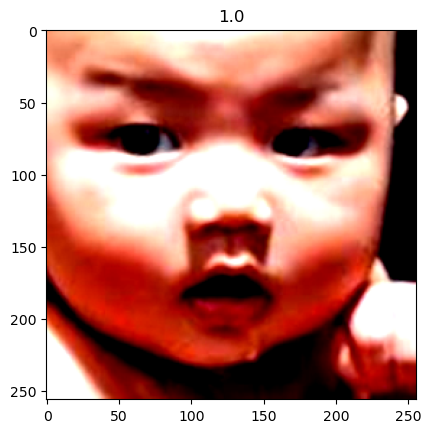

In [15]:
imshow(images[0], labels[0])

In [16]:
def show_transformed_images(images, labels):
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([ 1., 26.,  2., 15., 84., 18., 26., 41.,  8., 27., 35., 61.,  9., 29.,
        47.,  2.,  1.,  5., 23., 53.,  3.,  1.,  7.,  1., 64., 75., 13., 86.,
        16., 31., 22., 79.], dtype=torch.float64)


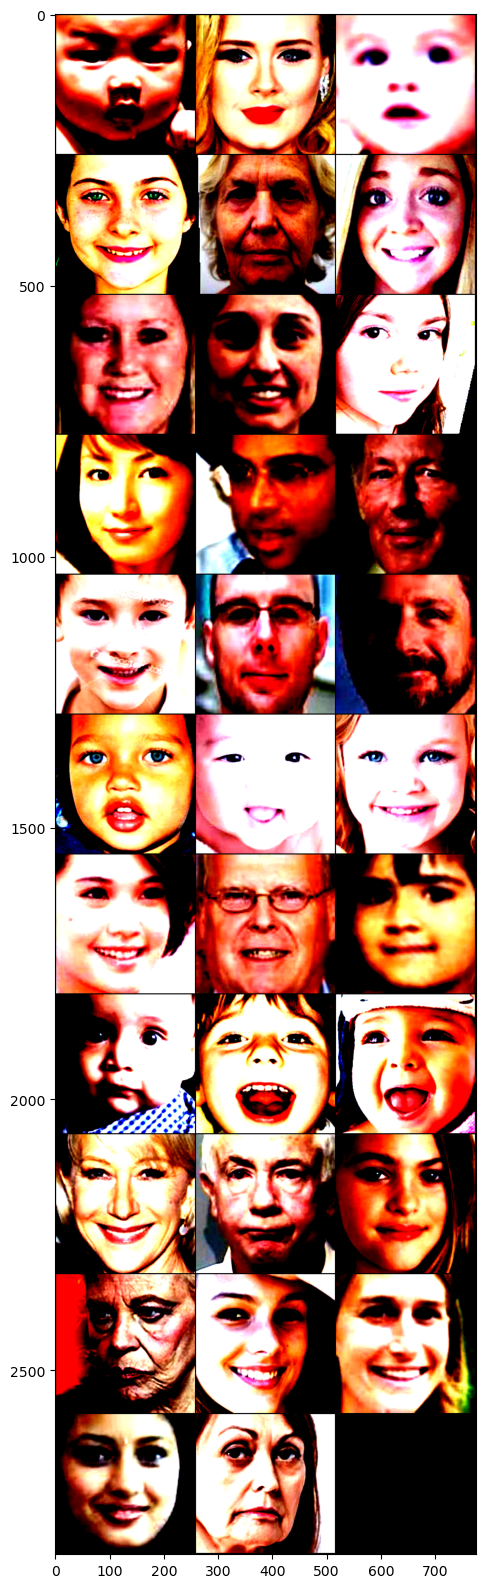

In [17]:
show_transformed_images(images, labels)

In [18]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev="cpu"
    return torch.device(dev)

device = set_device()

In [19]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, ages in train_loader:
        images, ages = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), ages.view(-1,1).float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation phase
    model.eval()  # Set model to evaluate mode
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), ages.view(-1,1).float())
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.3f}, Validation Loss: {val_loss:.3f}')

Epoch [1/20], Train Loss: 787.459, Validation Loss: 787.823
Epoch [2/20], Train Loss: 787.124, Validation Loss: 787.466
Epoch [3/20], Train Loss: 786.747, Validation Loss: 787.220
Epoch [4/20], Train Loss: 786.421, Validation Loss: 786.806
Epoch [5/20], Train Loss: 786.112, Validation Loss: 786.500
Epoch [6/20], Train Loss: 785.945, Validation Loss: 786.253
Epoch [7/20], Train Loss: 785.698, Validation Loss: 785.978
Epoch [8/20], Train Loss: 785.420, Validation Loss: 785.764
Epoch [9/20], Train Loss: 785.186, Validation Loss: 785.594
Epoch [10/20], Train Loss: 784.969, Validation Loss: 785.386
Epoch [11/20], Train Loss: 784.836, Validation Loss: 785.228
Epoch [12/20], Train Loss: 784.650, Validation Loss: 785.028
Epoch [13/20], Train Loss: 784.545, Validation Loss: 784.867
Epoch [14/20], Train Loss: 784.378, Validation Loss: 784.741
Epoch [15/20], Train Loss: 784.296, Validation Loss: 784.592
Epoch [16/20], Train Loss: 784.142, Validation Loss: 784.497
Epoch [17/20], Train Loss: 784.05

In [31]:
# Test model
model.eval()
total_loss = 0
total_mae = 0 # mean absolute error
with torch.no_grad():
    for images, ages in test_loader:
        images, ages = images.to(device), ages.to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), ages.view(-1, 1).float())
        total_loss += loss.item() * images.size(0)
    
        mae = torch.mean(torch.abs(outputs.squeeze() - ages.float())).item()
        total_mae += mae * images.size(0)
    
avg_loss = total_loss / len(test_loader.dataset)
avg_mae = total_mae / len(test_loader.dataset)
print(f'Test Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}')

Test Loss: 606.8038, MAE: 20.9295


In [32]:
torch.save(model.state_dict(), 'age_estimation_model.pth')

In [33]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load('age_estimation_model.pth'))
model.eval()

new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 1)

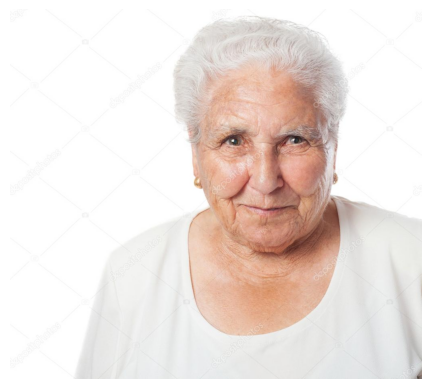

Predicted Age: 33.93123245239258


In [38]:
img_path = 'images/old_woman.jpg'
img = Image.open(img_path)

input_tensor = transform(img).unsqueeze(0)
new_model.eval()

output = model(input_tensor)
    
predicted_age = output.item()
plt.imshow(img)
plt.axis('off')
plt.show()
print(f'Predicted Age: {predicted_age}')